<a href="https://colab.research.google.com/github/tmedeirosb/modelo_ifrn_integrado/blob/master/PAPER_MDPI_REVIEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper: Predictive models for imbalanced data: a school dropout perspective

## Abstract: 
In this paper we propose to investigate problems related to imbalanced data on predictive models of school dropout rates, such as  ``Accuracy Paradox'' (a phenomenon that masks obtained results), and how to improve the correctness in a minority class. For this, we analyze the performance of classifiers based on Decision Tree and MLP (Multilayer Perceptron) Neural Networks, with and without the use of a downsample data balancing technique. In order to analyze the performance of these classifiers, the  G-mean, AUC, Recall, and precision metrics were used. The experimental results using real school dropout data indicate that G-means metric is more robust to the ``Accuracy Paradox'' and that the use of downsampling data balancing technique increases the performance of predictive models significantly.

TODO RATIO SUGERIDO POR AFFONSO

Import packages 

In [0]:
#import packages

#graphs
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()

#google drive
import os
from google.colab import drive

#data crawling
import numpy as np
import pandas as pd

#evalueting models
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn import model_selection

#classic models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#imbalanced
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from imblearn.ensemble import BalanceCascade
import operator
from sklearn.base import clone
from imblearn.metrics import geometric_mean_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline

#show graphs in notebook
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Import database. The construct the database is available in https://github.com/tmedeirosb/modelo_ifrn_integrado/blob/master/versao_2/workflow_criando_base.ipynb 

In [0]:
#impor database
drive.mount('/content/drive')
dados_tunning = pd.read_json('/content/drive/My Drive/Colab Notebooks/dados/dados_workflow_ivan.json')
dados = dados_tunning.copy()
dados.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(8908, 33)

Functions to pre-process data (remove NaN, dummies transform),  and evaluate the model



In [0]:
#config enviroment
#show all columns
pd.set_option('display.max_columns', None)

#clean the NaN
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    #print(dados_clean.info())
    
    return (dados_clean, y)

#plot roc curve
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')
    
#evaluating models
def evaluating(name, model, ytest, ypred, Xtest, results):
  
    #matriz de confusao (AP: atual positivo, AN: atual negativo, PP: pred. positivo, PN: pred. negativo)
    #     AN | AP 
    # --------------
    # PN: TN | FN
    # PP: FP | TP

    #Text summary of the precision, recall, F1 score for each class
    #precision = TP/(TP+FP); TN/(TN+FN) 
    #recall    = TP/(TP+FN); TN/(TN+FP)
    class_report = classification_report(ytest, ypred, output_dict=True)

    print( class_report )    
    
    #Evaluating
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    #tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()    
    #print(tp)
    #print(tn)
    #print(fn)
    #print(fp)
    #print( tn/(tn+fp) )
    
    #CURVA ROC
    fig = plt.figure()
    y_probas = cross_val_predict(model, Xtest, ytest, cv=10, method="predict_proba") 

    y_scores = y_probas[:, 1]   # score = proba of positive class 
    fpr, tpr, thresholds = roc_curve(ytest, y_scores)

    plot_roc_curve(fpr, tpr) 
    plt.show()
    print("AUC: %f" % roc_auc_score(ytest, y_scores))
    
    
    auc = roc_auc_score(ytest, y_scores)
    g = geometric_mean_score(ytest, ypred)
   
  
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
    #MACRO is UAR
    
        #atualiza o frame de results
    results = results.append( pd.DataFrame({'name' : name, 
                                  'precision' : [class_report["1"]["precision"]], 
                                  'recall' : [class_report["1"]["recall"]], 
                                  'f1' : [class_report["1"]["f1-score"]], 
                                  'precision_w' : [class_report["macro avg"]["precision"]], 
                                  'recall_w' : [class_report["macro avg"]["recall"]], 
                                  'f1_w' : [class_report["macro avg"]["f1-score"]], 
                                  'auc' : [auc], 
                                  'g-mean' : [g]
                                  }
                            ), ignore_index=True

                  )   
    
    return results

    
def plot_alg_comp(results, names):
  fig = plt.figure()
  fig.suptitle('Algorithm Comparison')
  ax = fig.add_subplot(111)
  plt.boxplot( results )
  ax.set_xticklabels( names )
  plt.xticks(rotation=90)
  plt.show()

#metric recall min
def recall_min(y_true, y_pred):
  tn = confusion_matrix(y_true, y_pred)[0, 0]
  fp = confusion_matrix(y_true, y_pred)[0, 1]
  return tn/(tn+fp)


Function que define os parâmetros dos modelos clássicos (DT, MLP) e do GridSearch, a fim de selecionar o melhor modelo

In [0]:
def select_model(Xtrain, Xtest, ytrain, ytest):
    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "DecisionTree",
            "estimator": DecisionTreeClassifier(),
            "hyperparameters":
                {
                    "criterion": ["gini", "entropy"],
                    #"min_samples_split": [2],
                    "max_depth": [None, 3, 5],
                    #"min_samples_leaf": [1],
                    "max_leaf_nodes": [None, 5, 10, 20]
                }
        },
        {
            "name":"MLP",
            "estimator": MLPClassifier(),
            "hyperparameters":
            {
                'solver': ['lbfgs'], 
                'max_iter': [200],
                'alpha': 10.0 ** -np.arange(1, 4), 
                'hidden_layer_sizes':np.arange(5, 20, 3), 
                'random_state':[0, 42]
            }            
        },
        #{
        #    "name": "RF",
        #    "estimator": RandomForestClassifier(),
        #    "hyperparameters":
        #        {
        #            "max_features": ["auto"],
        #            'n_estimators': [10, 30, 100, 200, 300]
        #        }
        #}
    ]      
   
    results = []
    names = []    
         
    #for each model traing and evaluating
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        #find best param
        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10, 
                            verbose=1,
                            n_jobs = -1,
                            scoring=make_scorer(geometric_mean_score))
                            #scoring='recall_macro')
                            #scoring='accuracy')
                            #scoring=make_scorer(recall_min))
        
        grid.fit(Xtrain, ytrain)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}".format(model["best_params"]))
                
    return models

Define os atributos da base de dados e, caso ainda tenha valores NAN, substituti por -1

In [0]:
#select attributes
atributos = [
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]

dados = dados[atributos]

#fill NAN
dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

#use original data
dados = dados[dados.artificial == 0]

print(dados.classe.value_counts())

dados.head(2)

1    7369
0     349
Name: classe, dtype: int64


,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaI90H_dependencia,LnguaPortuguesaeLiteraturaI90H_freq,MatemticaI120H,MatemticaI120H_dependencia,MatemticaI120H_freq,acompanhamento,aluno_exclusivo_rede_publica,artificial,classe,conceito,conceito_freq,descricao_area_residencial,descricao_companhia_domiciliar,descricao_estado_civil,descricao_historico,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_trabalho,idade,pessoa_fisica__sexo,possui_necessidade_especial,qnt_pc,qnt_salarios,qtd_pessoas_domicilio,sigla,tempo_entre_conclusao_ingresso
0,68.0,0,100.0,66.0,0,100.0,0,False,0,1,B,A,Urbana,Mãe,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Branca,Ensino fundamental incompleto,Mãe,Não informado,15,F,False,0,1,2,LAJ,1
10,61.0,0,100.0,60.0,0,100.0,0,False,0,1,B,A,Urbana,Pais,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino médio completo,Ensino médio completo,Parda,Ensino médio completo,Mãe,Não informado,15,M,True,0,2,5,CANG,2


Separa os dados em 25% de teste e 75% de treino. Os dois folds são estratificados de acordo com o balanceamento da classe de evasão, a fim de manter a proporção dos dados do conjunto original. 

Esse conjunto de dados será utilizado em todos os modelos

In [0]:
#split data test and training. Stratify like imbalanced classes
X, y = preparing_data(dados)
print(X.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42, stratify = y)

(7718, 31)
(7718, 31)
(7718, 151)


## Unbalance Models(MLP, DT)

In [0]:
res_models = select_model(Xtrain, Xtest, ytrain, ytest)

DecisionTree
------------
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score: 0.6632967675315518
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None}
MLP
---
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:  1.2min


Best Score: 0.6976525292962994
Best Parameters: {'alpha': 0.1, 'hidden_layer_sizes': 8, 'max_iter': 200, 'random_state': 42, 'solver': 'lbfgs'}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished


Avalia os modelos clássicos. 



DecisionTree
------------
{'0': {'precision': 0.4880952380952381, 'recall': 0.47126436781609193, 'f1-score': 0.47953216374269, 'support': 87}, '1': {'precision': 0.9750812567713976, 'recall': 0.9766684753119913, 'f1-score': 0.9758742206560043, 'support': 1843}, 'accuracy': 0.9538860103626943, 'macro avg': {'precision': 0.7315882474333179, 'recall': 0.7239664215640416, 'f1-score': 0.7277031921993471, 'support': 1930}, 'weighted avg': {'precision': 0.9531290372766692, 'recall': 0.9538860103626943, 'f1-score': 0.953500252287373, 'support': 1930}}


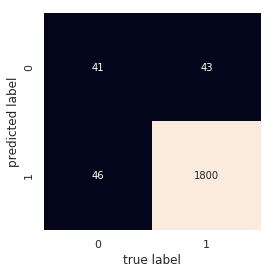

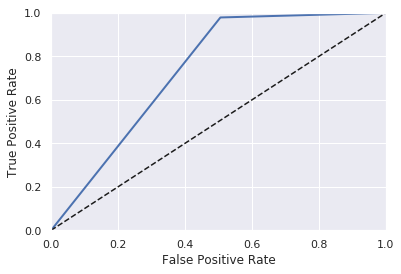

AUC: 0.736546


MLP
---
{'0': {'precision': 0.2752808988764045, 'recall': 0.5632183908045977, 'f1-score': 0.369811320754717, 'support': 87}, '1': {'precision': 0.978310502283105, 'recall': 0.9300054259359739, 'f1-score': 0.9535465924895689, 'support': 1843}, 'accuracy': 0.9134715025906736, 'macro avg': {'precision': 0.6267957005797548, 'recall': 0.7466119083702858, 'f1-score': 0.6616789566221429, 'support': 1930}, 'weighted avg': {'precision': 0.9466195305233212, 'recall': 0.9134715025906736, 'f1-score': 0.9272331372352, 'support': 1930}}


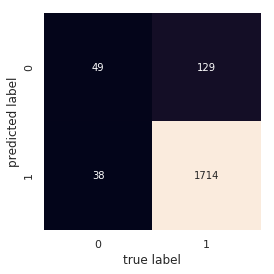

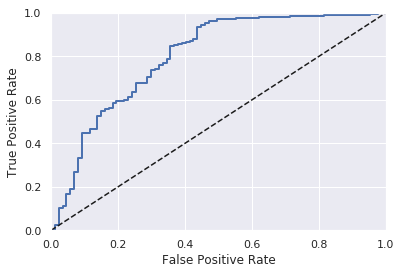

AUC: 0.798342


In [0]:
results = pd.DataFrame({'name' : [], 'precision' : [], 'recall' : [], 'f1' : [], 
                        'precision_w' : [], 'recall_w' : [], 'f1_w' : [],
                        'auc' : [], 'g-mean' : []})

#avaliacao individual por modelo
for model in res_models:        
    print('\n\n'+model['name'])
    print('-'*len(model['name']))

    #sim
    ypred = model['best_model'].predict(Xtest)
    results = evaluating(model['name'], model['best_model'], ytest, ypred, Xtest, results)
    

In [0]:
#balanceamento de dados
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(Xtrain, ytrain)

#mantem em formato de dataframe
X_under = pd.DataFrame(X_under)
X_under.columns = Xtrain.columns

print(Xtrain.shape)
X_under.shape

unique_elements, counts_elements = np.unique(ytrain, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

unique_elements, counts_elements = np.unique(y_under, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

(5788, 151)
Frequency of unique values of the said array:
[[   0    1]
 [ 262 5526]]
Frequency of unique values of the said array:
[[  0   1]
 [262 262]]


{'0': {'precision': 0.1658878504672897, 'recall': 0.8160919540229885, 'f1-score': 0.2757281553398058, 'support': 87}, '1': {'precision': 0.9893475366178429, 'recall': 0.8062940857297883, 'f1-score': 0.8884902840059791, 'support': 1843}, 'accuracy': 0.8067357512953368, 'macro avg': {'precision': 0.5776176935425663, 'recall': 0.8111930198763884, 'f1-score': 0.5821092196728924, 'support': 1930}, 'weighted avg': {'precision': 0.9522278512835952, 'recall': 0.8067357512953368, 'f1-score': 0.860868364216364, 'support': 1930}}


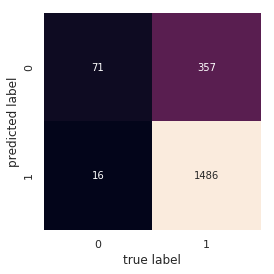

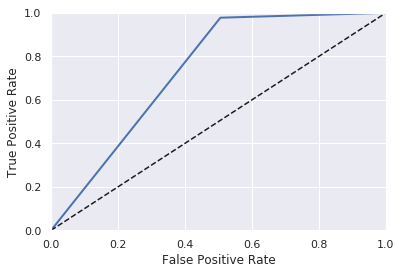

AUC: 0.736003


In [0]:
#rus = RandomUnderSampler(replacement=False)
#X_train_subsample, y_train_subsample = rus.fit_sample(Xtrain, ytrain)

#undersample_dt = make_imb_pipeline(RandomUnderSampler(), DecisionTreeClassifier(res_models[0]['best_params']))
#undersample_dt = make_imb_pipeline(RandomUnderSampler(random_state=42), clone(res_models[0]['best_model']))

undersample_dt =  clone(res_models[0]['best_model'])

#treino
undersample_dt.fit(X_under, y_under)

#predicao
ypred = undersample_dt.predict(Xtest)

#avaliação 
results = evaluating('DT Undersample', undersample_dt, ytest, ypred, Xtest, results)

# boxplot algorithm comparison
#plot_alg_comp(results, names)

{'0': {'precision': 0.23127035830618892, 'recall': 0.8160919540229885, 'f1-score': 0.3604060913705584, 'support': 87}, '1': {'precision': 0.9901417128773875, 'recall': 0.8719479110146501, 'f1-score': 0.9272937103289093, 'support': 1843}, 'accuracy': 0.8694300518134715, 'macro avg': {'precision': 0.6107060355917882, 'recall': 0.8440199325188193, 'f1-score': 0.6438499008497338, 'support': 1930}, 'weighted avg': {'precision': 0.9559335222827273, 'recall': 0.8694300518134715, 'f1-score': 0.9017397088525484, 'support': 1930}}


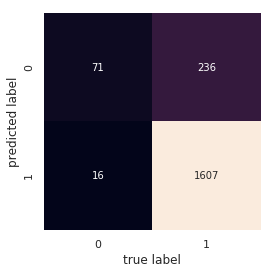

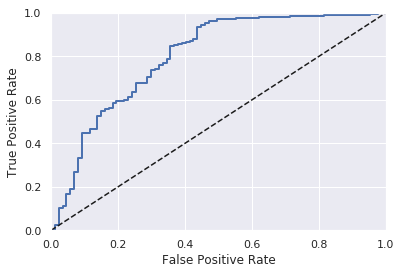

AUC: 0.798342


In [0]:
#undersample_mlp = make_imb_pipeline(RandomUnderSampler(random_state=42), clone(res_models[1]['best_model']))
undersample_mlp = clone(res_models[1]['best_model'])

#treino
undersample_mlp.fit(X_under, y_under)

#predicao
ypred = undersample_mlp.predict(Xtest)

#avaliação 
results = evaluating('MLP Undersample', undersample_mlp, ytest, ypred, Xtest, results)

In [0]:
#SMOTE
from imblearn.over_sampling import SMOTE

#balanceamento de dados
rsm = SMOTE(random_state=42)
X_smote, y_smote = rsm.fit_resample(Xtrain, ytrain)

#mantem em formato de dataframe
X_smote = pd.DataFrame(X_smote)
X_smote.columns = Xtrain.columns

print(Xtrain.shape)
X_smote.shape

unique_elements, counts_elements = np.unique(ytrain, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

unique_elements, counts_elements = np.unique(y_smote, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

(5788, 151)
Frequency of unique values of the said array:
[[   0    1]
 [ 262 5526]]
Frequency of unique values of the said array:
[[   0    1]
 [5526 5526]]


{'0': {'precision': 0.3853211009174312, 'recall': 0.4827586206896552, 'f1-score': 0.4285714285714286, 'support': 87}, '1': {'precision': 0.9752883031301482, 'recall': 0.9636462289744981, 'f1-score': 0.9694323144104804, 'support': 1843}, 'accuracy': 0.9419689119170984, 'macro avg': {'precision': 0.6803047020237898, 'recall': 0.7232024248320766, 'f1-score': 0.6990018714909545, 'support': 1930}, 'weighted avg': {'precision': 0.948693926657347, 'recall': 0.9419689119170984, 'f1-score': 0.9450515387275801, 'support': 1930}}


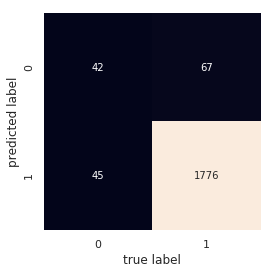

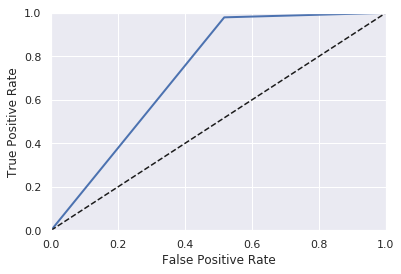

AUC: 0.731070


In [0]:
smote_dt =  clone(res_models[0]['best_model'])

#treino
smote_dt.fit(X_smote, y_smote)

#predicao
ypred = smote_dt.predict(Xtest)

#avaliação 
results = evaluating('DT SMOTE', smote_dt, ytest, ypred, Xtest, results)

{'0': {'precision': 0.238562091503268, 'recall': 0.8390804597701149, 'f1-score': 0.3715012722646311, 'support': 87}, '1': {'precision': 0.9913793103448276, 'recall': 0.8735756918068367, 'f1-score': 0.9287568503028555, 'support': 1843}, 'accuracy': 0.872020725388601, 'macro avg': {'precision': 0.6149707009240478, 'recall': 0.8563280757884758, 'f1-score': 0.6501290612837433, 'support': 1930}, 'weighted avg': {'precision': 0.9574440263866847, 'recall': 0.872020725388601, 'f1-score': 0.9036370392721169, 'support': 1930}}


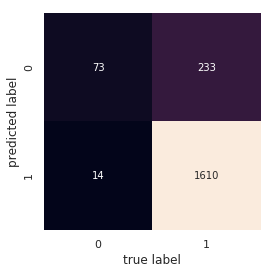

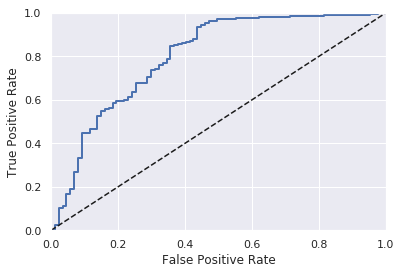

AUC: 0.798342


In [0]:
#undersample_mlp = make_imb_pipeline(RandomUnderSampler(random_state=42), clone(res_models[1]['best_model']))
smote_mlp = clone(res_models[1]['best_model'])

#treino
smote_mlp.fit(X_smote, y_smote)

#predicao
ypred = smote_mlp.predict(Xtest)

#avaliação 
results = evaluating('MLP SMOTE', smote_mlp, ytest, ypred, Xtest, results)

In [0]:
#He, Haibo, Yang Bai, Edwardo A. Garcia, and Shutao Li. “ADASYN: Adaptive synthetic sampling approach for imbalanced learning,” In IEEE International Joint Conference on Neural Networks (IEEE World Congress on Computational Intelligence), pp. 1322-1328, 2008.

#SMOTE
from imblearn.over_sampling import ADASYN

#balanceamento de dados ADASYN
X_ada, y_ada = ADASYN(random_state=42).fit_resample(Xtrain, ytrain)

#mantem em formato de dataframe
X_ada = pd.DataFrame(X_ada)
X_ada.columns = Xtrain.columns

print(Xtrain.shape)
X_ada.shape

unique_elements, counts_elements = np.unique(ytrain, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

unique_elements, counts_elements = np.unique(y_ada, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))


(5788, 151)
Frequency of unique values of the said array:
[[   0    1]
 [ 262 5526]]
Frequency of unique values of the said array:
[[   0    1]
 [5537 5526]]


{'0': {'precision': 0.40425531914893614, 'recall': 0.4367816091954023, 'f1-score': 0.419889502762431, 'support': 87}, '1': {'precision': 0.9733115468409586, 'recall': 0.9696147585458491, 'f1-score': 0.9714596357705897, 'support': 1843}, 'accuracy': 0.9455958549222798, 'macro avg': {'precision': 0.6887834329949474, 'recall': 0.7031981838706257, 'f1-score': 0.6956745692665103, 'support': 1930}, 'weighted avg': {'precision': 0.9476597894268622, 'recall': 0.9455958549222798, 'f1-score': 0.9465961116401701, 'support': 1930}}


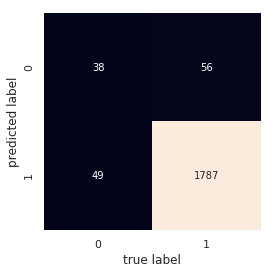

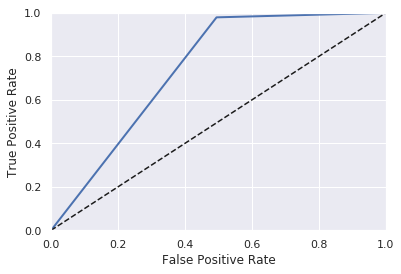

AUC: 0.742564


In [0]:
ada_dt =  clone(res_models[0]['best_model'])

#treino
ada_dt.fit(X_ada, y_ada)

#predicao
ypred = ada_dt.predict(Xtest)

#avaliação 
results = evaluating('DT ADASYN', ada_dt, ytest, ypred, Xtest, results)

{'0': {'precision': 0.22018348623853212, 'recall': 0.8275862068965517, 'f1-score': 0.34782608695652184, 'support': 87}, '1': {'precision': 0.990642545227698, 'recall': 0.8616386326641345, 'f1-score': 0.9216482878699943, 'support': 1843}, 'accuracy': 0.8601036269430051, 'macro avg': {'precision': 0.605413015733115, 'recall': 0.8446124197803431, 'f1-score': 0.6347371874132581, 'support': 1930}, 'weighted avg': {'precision': 0.9559120073354402, 'recall': 0.8601036269430051, 'f1-score': 0.8957816912485062, 'support': 1930}}


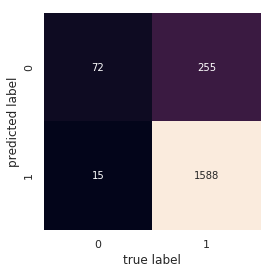

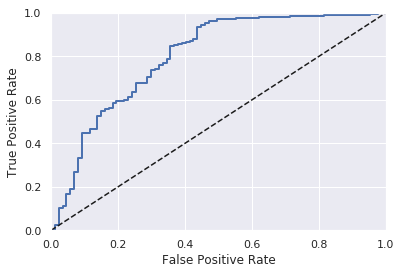

AUC: 0.798342


In [0]:
ada_mlp = clone(res_models[1]['best_model'])

#treino
ada_mlp.fit(X_ada, y_ada)

#predicao
ypred = ada_mlp.predict(Xtest)

#avaliação 
results = evaluating('MLP ADASYN', ada_mlp, ytest, ypred, Xtest, results)

##Utilizando técnicas robustas ao desbalanceamento

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.4min finished


{'n_estimators': 100}
0.8667039652101489
{'0': {'precision': 0.285140562248996, 'recall': 0.8160919540229885, 'f1-score': 0.4226190476190476, 'support': 87}, '1': {'precision': 0.9904818560380726, 'recall': 0.903418339663592, 'f1-score': 0.9449489216799092, 'support': 1843}, 'accuracy': 0.8994818652849741, 'macro avg': {'precision': 0.6378112091435343, 'recall': 0.8597551468432902, 'f1-score': 0.6837839846494784, 'support': 1930}, 'weighted avg': {'precision': 0.9586866785460261, 'recall': 0.8994818652849741, 'f1-score': 0.9214034817611035, 'support': 1930}}


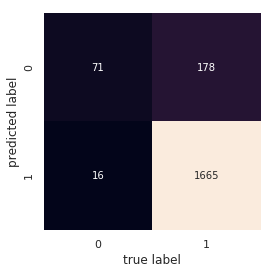

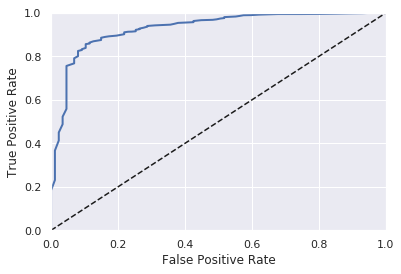

AUC: 0.928986


In [0]:
#BalancedBaggingClassifier

#classificador base DT
tree = DecisionTreeClassifier(max_features='auto')

#otimiza parâmetros
parameters = {'n_estimators': (10, 30, 100, 200, 300)}

grid = GridSearchCV(BalancedBaggingClassifier(base_estimator=tree),
                    param_grid=parameters,
                    cv=10, 
                    verbose=1,
                    n_jobs = -1,
                    scoring=make_scorer(geometric_mean_score))
                    #scoring='recall_macro')
                    #scoring='accuracy')

#treina
grid.fit(Xtrain, ytrain)

#exibe melhor modelo
print(grid.best_params_)
print(grid.best_score_)
ensemble = grid.best_estimator_

#predicao
ypred_ensemble = ensemble.predict(Xtest)

#avaliacao
results = evaluating('Balanced Bagging', ensemble, ytest, ypred_ensemble, Xtest, results)

,name,precision,recall,f1,precision_w,recall_w,f1_w,auc,g-mean
0,DecisionTree,0.975081,0.976668,0.975874,0.731588,0.723966,0.727703,0.736546,0.678431
1,MLP,0.978311,0.930005,0.953547,0.626796,0.746612,0.661679,0.798342,0.723738
2,DT Undersample,0.989348,0.806294,0.888490,0.577618,0.811193,0.582109,0.736003,0.811178
3,MLP Undersample,0.990142,0.871948,0.927294,0.610706,0.844020,0.643850,0.798342,0.843558
4,DT SMOTE,0.975288,0.963646,0.969432,0.680305,0.723202,0.699002,0.731070,0.682062
5,MLP SMOTE,0.991379,0.873576,0.928757,0.614971,0.856328,0.650129,0.798342,0.856154
6,DT ADASYN,0.973312,0.969615,0.971460,0.688783,0.703198,0.695675,0.742564,0.650776
7,MLP ADASYN,0.990643,0.861639,0.921648,0.605413,0.844612,0.634737,0.798342,0.844441
8,Balanced Bagging,0.990482,0.903418,0.944949,0.637811,0.859755,0.683784,0.928986,0.858646


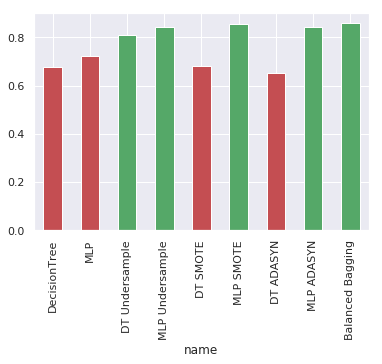

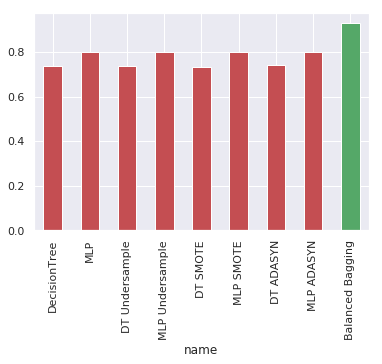

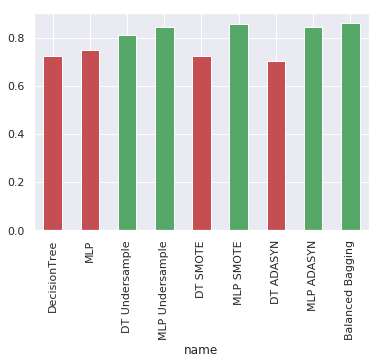

In [0]:
#comparando todos os modelos
#all_models = models_sem + models_under + models_smote
#plot_comp_models(all_models)

my_colors = ['g', 'b']*5 # <-- this concatenates the list to itself 5 times.
my_colors = [(0.5,0.4,0.5), (0.75, 0.75, 0.25)]*5 # <-- make two custom RGBs and repeat/alternate them over all the bar elements.
my_colors = [(x/20.0, x/40.0, 0.75) for x in range(len(results))] # <-

#results.plot.bar(x='name', y='g-mean', rot=90, color=my_colors)
results.plot.bar(x='name', y='g-mean', rot=90, color=np.where(results["g-mean"]>0.8, 'g', 'r'), legend=False)
results.plot.bar(x='name', y='auc', rot=90, color=np.where(results["auc"]>0.8, 'g', 'r'), legend=False)
results.plot.bar(x='name', y='recall_w', rot=90, color=np.where(results["recall_w"]>0.8, 'g', 'r'), legend=False)

results

In [0]:
pd.set_option("display.precision", 3)
print(results.to_latex())

\begin{tabular}{llrrrrrrrr}
\toprule
{} &              name &  precision &  recall &     f1 &  precision\_w &  recall\_w &   f1\_w &    auc &  g-mean \\
\midrule
0 &      DecisionTree &      0.975 &   0.977 &  0.976 &        0.732 &     0.724 &  0.728 &  0.737 &   0.678 \\
1 &               MLP &      0.978 &   0.930 &  0.954 &        0.627 &     0.747 &  0.662 &  0.798 &   0.724 \\
2 &    DT Undersample &      0.989 &   0.806 &  0.888 &        0.578 &     0.811 &  0.582 &  0.736 &   0.811 \\
3 &   MLP Undersample &      0.990 &   0.872 &  0.927 &        0.611 &     0.844 &  0.644 &  0.798 &   0.844 \\
4 &          DT SMOTE &      0.975 &   0.964 &  0.969 &        0.680 &     0.723 &  0.699 &  0.731 &   0.682 \\
5 &         MLP SMOTE &      0.991 &   0.874 &  0.929 &        0.615 &     0.856 &  0.650 &  0.798 &   0.856 \\
6 &         DT ADASYN &      0.973 &   0.970 &  0.971 &        0.689 &     0.703 &  0.696 &  0.743 &   0.651 \\
7 &        MLP ADASYN &      0.991 &   0.862 &  0.922 

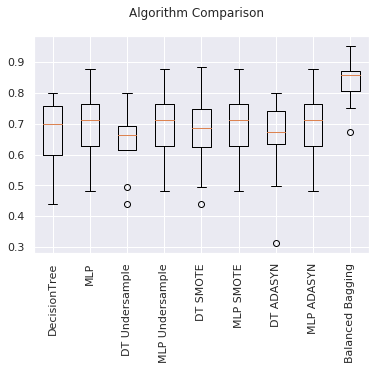

In [0]:
kfold = model_selection.KFold(n_splits=10, random_state=42)

results_g = []
names = []

#classic models
for model in res_models: 
  cv_results = model_selection.cross_val_score(model["best_model"], 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold, 
                                             scoring=make_scorer(geometric_mean_score))


  results_g.append(cv_results)
  names.append(model['name'])

#dt undersample
cv_results = model_selection.cross_val_score(undersample_dt, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring=make_scorer(geometric_mean_score))

results_g.append(cv_results)
names.append('DT Undersample')

#mlp undersample
cv_results = model_selection.cross_val_score(undersample_mlp, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring=make_scorer(geometric_mean_score))

results_g.append(cv_results)
names.append('MLP Undersample')

#DT SMOTE
cv_results = model_selection.cross_val_score(smote_dt, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring=make_scorer(geometric_mean_score))

results_g.append(cv_results)
names.append('DT SMOTE')

#mlp smote
cv_results = model_selection.cross_val_score(smote_mlp, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring=make_scorer(geometric_mean_score))

results_g.append(cv_results)
names.append('MLP SMOTE')

#DT ADASYN
cv_results = model_selection.cross_val_score(ada_dt, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring=make_scorer(geometric_mean_score))

results_g.append(cv_results)
names.append('DT ADASYN')

#MLP ADASYN
cv_results = model_selection.cross_val_score(ada_mlp, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring=make_scorer(geometric_mean_score))

results_g.append(cv_results)
names.append('MLP ADASYN')

#BALANCE BAGGING
cv_results = model_selection.cross_val_score(ensemble, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring=make_scorer(geometric_mean_score))
                                             
results_g.append(cv_results)
names.append('Balanced Bagging')
  
plot_alg_comp(results_g, names)

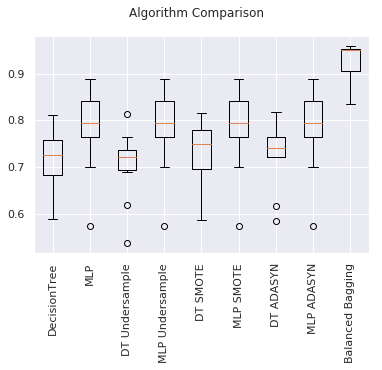

In [0]:
results_auc = []

#classic models
for model in res_models: 
  cv_results = model_selection.cross_val_score(model["best_model"], 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold, 
                                             scoring="roc_auc")


  results_auc.append(cv_results)
  
#dt undersample
cv_results = model_selection.cross_val_score(undersample_dt, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring="roc_auc")

results_auc.append(cv_results)


#mlp undersample
cv_results = model_selection.cross_val_score(undersample_mlp, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring="roc_auc")

results_auc.append(cv_results)


#DT SMOTE
cv_results = model_selection.cross_val_score(smote_dt, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring="roc_auc")

results_auc.append(cv_results)


#mlp smote
cv_results = model_selection.cross_val_score(smote_mlp, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring="roc_auc")

results_auc.append(cv_results)

#DT ADASYN
cv_results = model_selection.cross_val_score(ada_dt, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring="roc_auc")

results_auc.append(cv_results)


#MLP ADASYN
cv_results = model_selection.cross_val_score(ada_mlp, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring="roc_auc")

results_auc.append(cv_results)


#BALANCE BAGGING
cv_results = model_selection.cross_val_score(ensemble, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring="roc_auc")
                                             
results_auc.append(cv_results)

  
plot_alg_comp(results_auc, names)

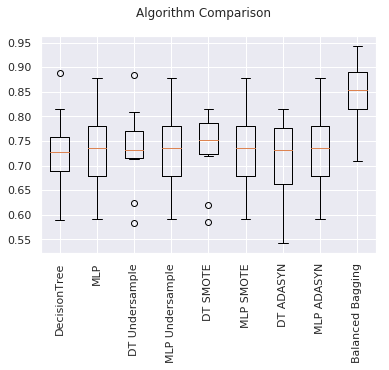

In [0]:
#recall macro
results_r = []

#classic models
for model in res_models: 
  cv_results = model_selection.cross_val_score(model["best_model"], 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold, 
                                             scoring="recall_macro")


  results_r.append(cv_results)
  
#dt undersample
cv_results = model_selection.cross_val_score(undersample_dt, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring="recall_macro")

results_r.append(cv_results)


#mlp undersample
cv_results = model_selection.cross_val_score(undersample_mlp, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring="recall_macro")

results_r.append(cv_results)


#DT SMOTE
cv_results = model_selection.cross_val_score(smote_dt, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring="recall_macro")

results_r.append(cv_results)


#mlp smote
cv_results = model_selection.cross_val_score(smote_mlp, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring="recall_macro")

results_r.append(cv_results)

#DT ADASYN
cv_results = model_selection.cross_val_score(ada_dt, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring="recall_macro")

results_r.append(cv_results)


#MLP ADASYN
cv_results = model_selection.cross_val_score(ada_mlp, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring="recall_macro")

results_r.append(cv_results)


#BALANCE BAGGING
cv_results = model_selection.cross_val_score(ensemble, 
                                             Xtest, 
                                             ytest, 
                                             cv=kfold,
                                             scoring="recall_macro")
                                             
results_r.append(cv_results)

  
plot_alg_comp(results_r, names)

## Teste de p-value, a fim de confirmar se os desempenhos são diferentes

In [0]:
#test p-value com G-MEAN
#https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
from scipy.stats import kruskal

print(results_g)

alpha = 0.05

i = 0
for r1 in results_g:
    j = 0
    for r2 in results_g:
      tmp = names[i]+" x "+names[j]
      print('*'*len(tmp))
      print(tmp)
      print('-'*len(tmp))
      
      
      stat, p = kruskal(r1, r2)
      print('Statistics=%.3f, p=%.3f' % (stat, p))
      # interpret
      if p > alpha:
        print('Same distributions (fail to reject H0)')
      else:
        print('Different distributions (reject H0)')
      
      j = j+1 
      
    i = i+1
  

[array([0.49867549, 0.43982113, 0.76631197, 0.79112207, 0.8010688 ,
       0.67234511, 0.7276587 , 0.69727172, 0.69758943, 0.57262427]), array([0.48249791, 0.61136772, 0.60845112, 0.82662971, 0.68012267,
       0.77324129, 0.70680453, 0.73582366, 0.87803459, 0.71643913]), array([0.4946807 , 0.43982113, 0.62398854, 0.73243671, 0.8010688 ,
       0.67048523, 0.61324414, 0.69130352, 0.69374594, 0.65938047]), array([0.48249791, 0.61136772, 0.60845112, 0.82662971, 0.68012267,
       0.77324129, 0.70680453, 0.73582366, 0.87803459, 0.71643913]), array([0.49601587, 0.43982113, 0.88486085, 0.73243671, 0.79436518,
       0.67234511, 0.61324414, 0.75313953, 0.69950326, 0.65938047]), array([0.48249791, 0.61136772, 0.60845112, 0.82662971, 0.68012267,
       0.77324129, 0.70680453, 0.73582366, 0.87803459, 0.71643913]), array([0.49734746, 0.3118778 , 0.62569111, 0.79112207, 0.8010688 ,
       0.67234511, 0.67368105, 0.7552761 , 0.69950326, 0.65570702]), array([0.48249791, 0.61136772, 0.60845112, 0.82

In [0]:
#test p-value com AUC
#https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
from scipy.stats import kruskal

print(results_auc)

alpha = 0.05

i = 0
for r1 in results_auc:
    j = 0
    for r2 in results_auc:
      tmp = names[i]+" x "+names[j]
      print('*'*len(tmp))
      print(tmp)
      print('-'*len(tmp))
      
      
      stat, p = kruskal(r1, r2)
      print('Statistics=%.3f, p=%.3f' % (stat, p))
      # interpret
      if p > alpha:
        print('Same distributions (fail to reject H0)')
      else:
        print('Different distributions (reject H0)')
      
      j = j+1 
      
    i = i+1


[array([0.6223545 , 0.58907104, 0.6893617 , 0.80994006, 0.81194296,
       0.72177822, 0.68119658, 0.73066298, 0.73663102, 0.76419082]), array([0.57407407, 0.78032787, 0.70106383, 0.85814186, 0.81550802,
       0.88811189, 0.76752137, 0.81031308, 0.85115865, 0.76268116]), array([0.61970899, 0.5363388 , 0.6893617 , 0.76448551, 0.81461676,
       0.72177822, 0.7224359 , 0.73895028, 0.73128342, 0.70591787]), array([0.57407407, 0.78032787, 0.70106383, 0.85814186, 0.81550802,
       0.88811189, 0.76752137, 0.81031308, 0.85115865, 0.76268116]), array([0.61970899, 0.5863388 , 0.68670213, 0.81543457, 0.81461676,
       0.72177822, 0.76645299, 0.78337937, 0.73395722, 0.76690821]), array([0.57407407, 0.78032787, 0.70106383, 0.85814186, 0.81550802,
       0.88811189, 0.76752137, 0.81031308, 0.85115865, 0.76268116]), array([0.61706349, 0.58360656, 0.78404255, 0.76448551, 0.81729055,
       0.72177822, 0.7224359 , 0.74171271, 0.73930481, 0.76419082]), array([0.57407407, 0.78032787, 0.70106383, 0.85

In [0]:
#test p-value com G-MEAN
#https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
from scipy.stats import kruskal

print(results_r)

alpha = 0.05

i = 0
for r1 in results_r:
    j = 0
    for r2 in results_r:
      tmp = names[i]+" x "+names[j]
      print('*'*len(tmp))
      print(tmp)
      print('-'*len(tmp))
      
      
      stat, p = kruskal(r1, r2)
      print('Statistics=%.3f, p=%.3f' % (stat, p))
      # interpret
      if p > alpha:
        print('Same distributions (fail to reject H0)')
      else:
        print('Different distributions (reject H0)')
      
      j = j+1 
      
    i = i+1
  

[array([0.61970899, 0.58907104, 0.8893617 , 0.76448551, 0.81461676,
       0.72452547, 0.68397436, 0.73066298, 0.73930481, 0.70591787]), array([0.59060847, 0.66721311, 0.66276596, 0.83341658, 0.71256684,
       0.78796204, 0.73311966, 0.75575506, 0.87923351, 0.7397343 ]), array([0.625     , 0.58360656, 0.88404255, 0.76173826, 0.80926916,
       0.72452547, 0.71965812, 0.77232965, 0.73930481, 0.71407005]), array([0.59060847, 0.66721311, 0.66276596, 0.83341658, 0.71256684,
       0.78796204, 0.73311966, 0.75575506, 0.87923351, 0.7397343 ]), array([0.61970899, 0.5863388 , 0.79202128, 0.81268731, 0.81461676,
       0.71903097, 0.76089744, 0.74171271, 0.73930481, 0.76690821]), array([0.59060847, 0.66721311, 0.66276596, 0.83341658, 0.71256684,
       0.78796204, 0.73311966, 0.75575506, 0.87923351, 0.7397343 ]), array([0.61970899, 0.54180328, 0.79202128, 0.76173826, 0.81461676,
       0.72452547, 0.68397436, 0.78061694, 0.73930481, 0.6557971 ]), array([0.59060847, 0.66721311, 0.66276596, 0.83